In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, getopt
import subprocess
import csv
import os
from tabulate import tabulate

def read_latencies(latency_types, concurrent, total_requests, conflict):
    output = []
    for latency_type in latency_types:
        output.append([])
    throughput = 0
    with open(os.getcwd() + '/outputs/local/nothrifty-batch/latencies_' + str(concurrent) + '_' + str(total_requests) + '_' + str(conflict) + '.csv') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        row_no = 0
        for row in spamreader:
            if (row_no == len(latency_types)):
                throughput = float(row[0])
                break
            for index in range(0, len(row)-1):
                output[row_no].append(float(row[index]))
            row_no += 1
    row_no = 0      
    for latency in latency_types:
        output[row_no].sort()
        output[row_no] = [ x * 1000 for x in output[row_no] ]
        row_no += 1
    return output, throughput

def get_percentiles(latencies):
    response = []
    response.append(round(np.percentile(latencies, 50), 6))
    response.append(round(np.percentile(latencies, 90), 6))
    response.append(round(np.percentile(latencies, 99), 6))
    response.append(round(np.percentile(latencies, 99.9), 6))
    response.append(round(np.percentile(latencies, 99.99), 6))
    response.append(round(latencies[-1], 6))
    return response


In [ ]:
# Parameters of test
total_requests = 1000000
concurrent = 100
conflicts = [0, 2, 25, 50, 100]
percentile_types = ['p50', 'p90', 'p99', 'p99.9', 'p99.99', 'max']
latency_types = ['leader_exec_latencies', 'leader_commit_latencies']
titles = ['Leader Execution', 'Leader Commit']

# Stores data read from test tiles to output and output_table_view
output1 = {}
output_table_view = {}
for latency_type in latency_types:
    output1[latency_type] = {}
    output_table_view[latency_type] = []
for conflict in conflicts:
    results, _ = read_latencies(latency_types, concurrent, total_requests, conflict)
    latency_type_count = 0
    for latency_type in latency_types:
        percentiles = get_percentiles(results[latency_type_count])
        output1[latency_type][conflict] = {
            'results': results[latency_type_count],
            'percentiles': percentiles
        }
        output_table_view[latency_type].append([conflict] + percentiles)
        latency_type_count += 1
    

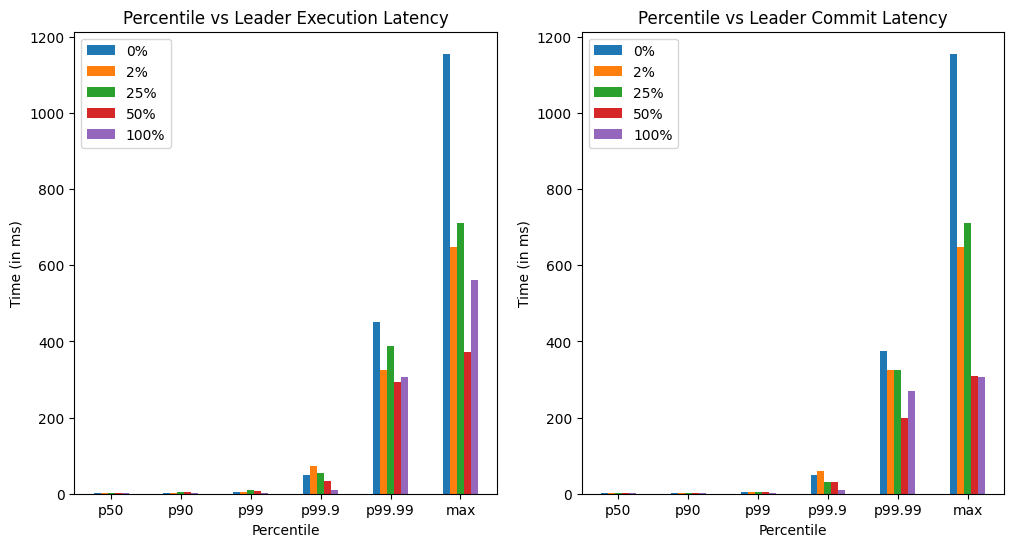

In [158]:
def plot_percentile_summary(conflict, total_conflicts, conflict_no, latency_type, percentiles, col, percentile_types):
    x = np.arange(len(percentiles))
    width = 0.1
    position = (width * (conflict_no + 0.5 - total_conflicts/2))
    axes[col].bar((x + position), percentiles, width, label = str(conflict) + '%')
    axes[col].set_title('Percentile vs ' + latency_type + ' Latency')
    axes[col].set_xlabel('Percentile')
    axes[col].set_ylabel('Time (in ms)')
    axes[col].set_xticks(x)
    axes[col].set_xticklabels(percentile_types)
    axes[col].legend()
    
total_tests = len(conflicts)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6 * len(latency_types), 6))
col = 0

for latency_type in latency_types:
    conflict_no = 0
    for conflict in conflicts:
        plot_percentile_summary(conflict, len(conflicts), conflict_no, titles[col], output1[latency_type][conflict]['percentiles'], col, percentile_types)
        conflict_no += 1
    col += 1
plt.show()

In [162]:
print('\nLeader Execution Latencies')
print(tabulate(output_table_view['leader_exec_latencies'], headers=['Conflict', 'p50', 'p90', 'p99', 'p99.9', 'p99.99', 'max'], tablefmt='orgtbl'))



Leader Execution Latencies
|   Conflict |   p50 |   p90 |   p99 |   p99.9 |   p99.99 |      max |
|------------+-------+-------+-------+---------+----------+----------|
|          0 | 1.866 | 2.514 | 4.341 | 49.8421 |  451.241 | 1155.56  |
|          2 | 1.886 | 2.6   | 5.563 | 72.364  |  324.973 |  647.179 |
|         25 | 1.689 | 3.9   | 9.008 | 55.6251 |  389.235 |  711.765 |
|         50 | 1.724 | 3.263 | 6.14  | 34.251  |  292.794 |  373.083 |
|        100 | 1.53  | 2.258 | 2.902 | 10.635  |  305.626 |  562.45  |


In [163]:
print('\nLeader Commit Latencies')
print(tabulate(output_table_view['leader_commit_latencies'], headers=['Conflict', 'p50', 'p90', 'p99', 'p99.9', 'p99.99', 'max'], tablefmt='orgtbl'))


Leader Commit Latencies
|   Conflict |   p50 |   p90 |     p99 |    p99.9 |   p99.99 |      max |
|------------+-------+-------+---------+----------+----------+----------|
|          0 | 1.86  | 2.507 | 4.327   | 49.7591  |  373.862 | 1155.55  |
|          2 | 1.879 | 2.588 | 4.80201 | 60.636   |  323.77  |  647.167 |
|         25 | 1.671 | 2.749 | 4.85601 | 30.0861  |  323.678 |  710.126 |
|         50 | 1.564 | 2.358 | 3.702   | 29.834   |  198.564 |  308.166 |
|        100 | 1.231 | 1.846 | 2.304   |  8.87001 |  268.628 |  305.606 |


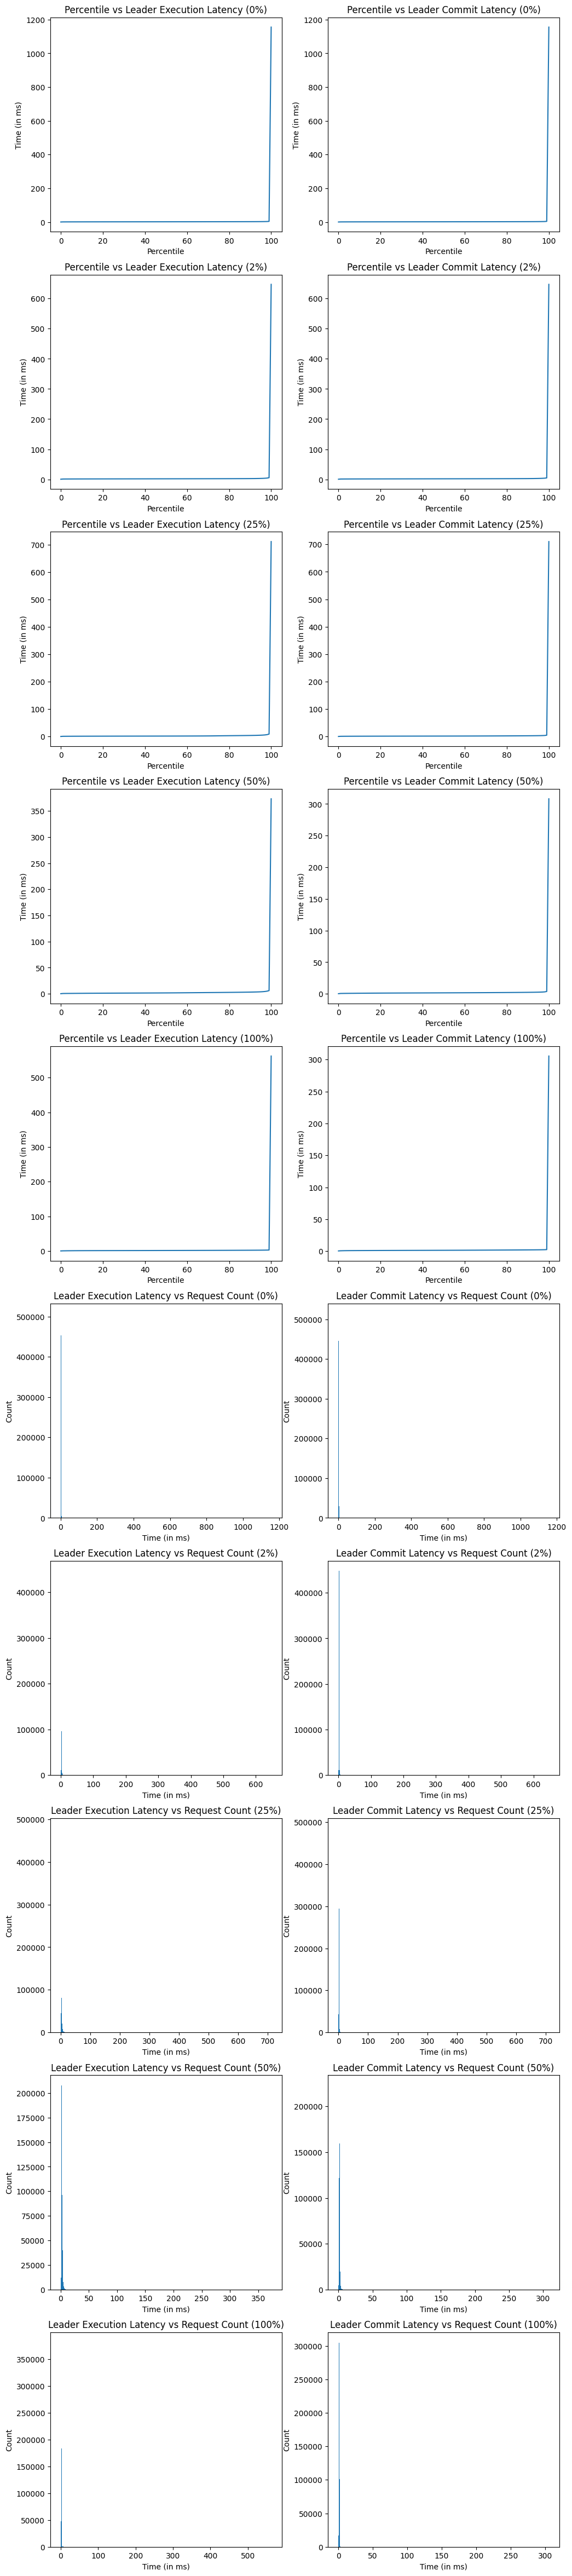

In [164]:
def plot_latency_metrics(latency_type, latencies, conflict, row, col):
    latencies_np = np.array(latencies)
    axes[row][col].hist(latencies_np, bins = 1000) 
    axes[row][col].set_title(latency_type + ' Latency vs Request Count (' + str(conflict) + '%)')
    axes[row][col].set_xlabel('Time (in ms)')
    axes[row][col].set_ylabel('Count')
    
def plot_percentile_metrics(latency_type, latencies, conflict, row, col):
    percentiles = [np.percentile(latencies, p) for p in range(101)]
    axes[row][col].plot(percentiles)
    axes[row][col].set_title('Percentile vs ' + latency_type + ' Latency (' + str(conflict) + '%)')
    axes[row][col].set_xlabel('Percentile')
    axes[row][col].set_ylabel('Time (in ms)')
    
total_tests = len(conflicts)
fig, axes = plt.subplots(nrows=total_tests * 2, ncols=len(latency_types), figsize=(6 * len(latency_types), total_tests * 12))
row = 0
for conflict in conflicts:
    result_count = 0
    for latency_type in latency_types:
        plot_percentile_metrics(titles[result_count], output1[latency_type][conflict]['results'], conflict, row, result_count)
        result_count += 1
    row += 1
for conflict in conflicts:
    result_count = 0
    for latency_type in latency_types:
        plot_latency_metrics(titles[result_count], output1[latency_type][conflict]['results'], conflict, row, result_count)
        result_count += 1
    row += 1
plt.show()

In [165]:
total_requests = 1000000
# concurrencies = [10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1800, 2000]
concurrencies = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 1800]
output2 = {}
conflict_throughputs = {}

for latency_type in latency_types:
    output2[latency_type] = {}
    for percentile_type in percentile_types:
        output2[latency_type][percentile_type] = {}
        for conflict in conflicts:
            output2[latency_type][percentile_type][conflict] = []

for conflict in conflicts:
    concurrent_count = 1
    conflict_throughputs[str(conflict)] = []
    for concurrent in concurrencies:
        try:
            results, throughput = read_latencies(latency_types, concurrent, total_requests, conflict)
        except:
            continue
        conflict_throughputs[str(conflict)].append(throughput)
        index = 0
        for percentile in percentile_types:
            type_no = 0
            for latency_type in latency_types:
                percentiles = get_percentiles(results[type_no])
                output2[latency_type][percentile][conflict].append(percentiles[index])
                type_no += 1
            index += 1
        concurrent_count += 1
      

In [167]:
print('\nConflict vs Throughput')
header = []
conflict_throughputs['Concurrency'] = concurrencies
for conflict in conflict_throughputs:
    header.append(str(conflict))
print(tabulate(conflict_throughputs, headers=header, tablefmt='orgtbl'))


Conflict vs Throughput
|       0 |       2 |      25 |      50 |     100 |   Concurrency |
|---------+---------+---------+---------+---------+---------------|
| 31843.7 | 31151.4 | 28882.2 | 34448.6 | 35650.9 |            10 |
| 45092.3 | 43824.6 | 40853.2 | 46496   | 58370.7 |            50 |
| 44042.1 | 44013.7 | 48093.2 | 55656.6 | 84406.6 |           100 |
| 51531.2 | 50472.4 | 41464.5 | 48742   | 62216.6 |           200 |
| 47512.1 | 46018.6 | 51202.9 | 50656.9 | 76964   |           400 |
| 50617.1 | 46684.3 | 47361.5 | 47032.5 | 82828.5 |           600 |
| 50573.2 | 45223.8 | 50983.2 | 42516.3 | 95556   |           800 |
| 47441   | 47894.5 | 54370.7 | 49701.9 | 82166.4 |          1000 |
| 45017.7 | 45167.9 | 51793.8 | 43908.3 | 84547.8 |          1500 |
|         |         |         |         |         |          1800 |


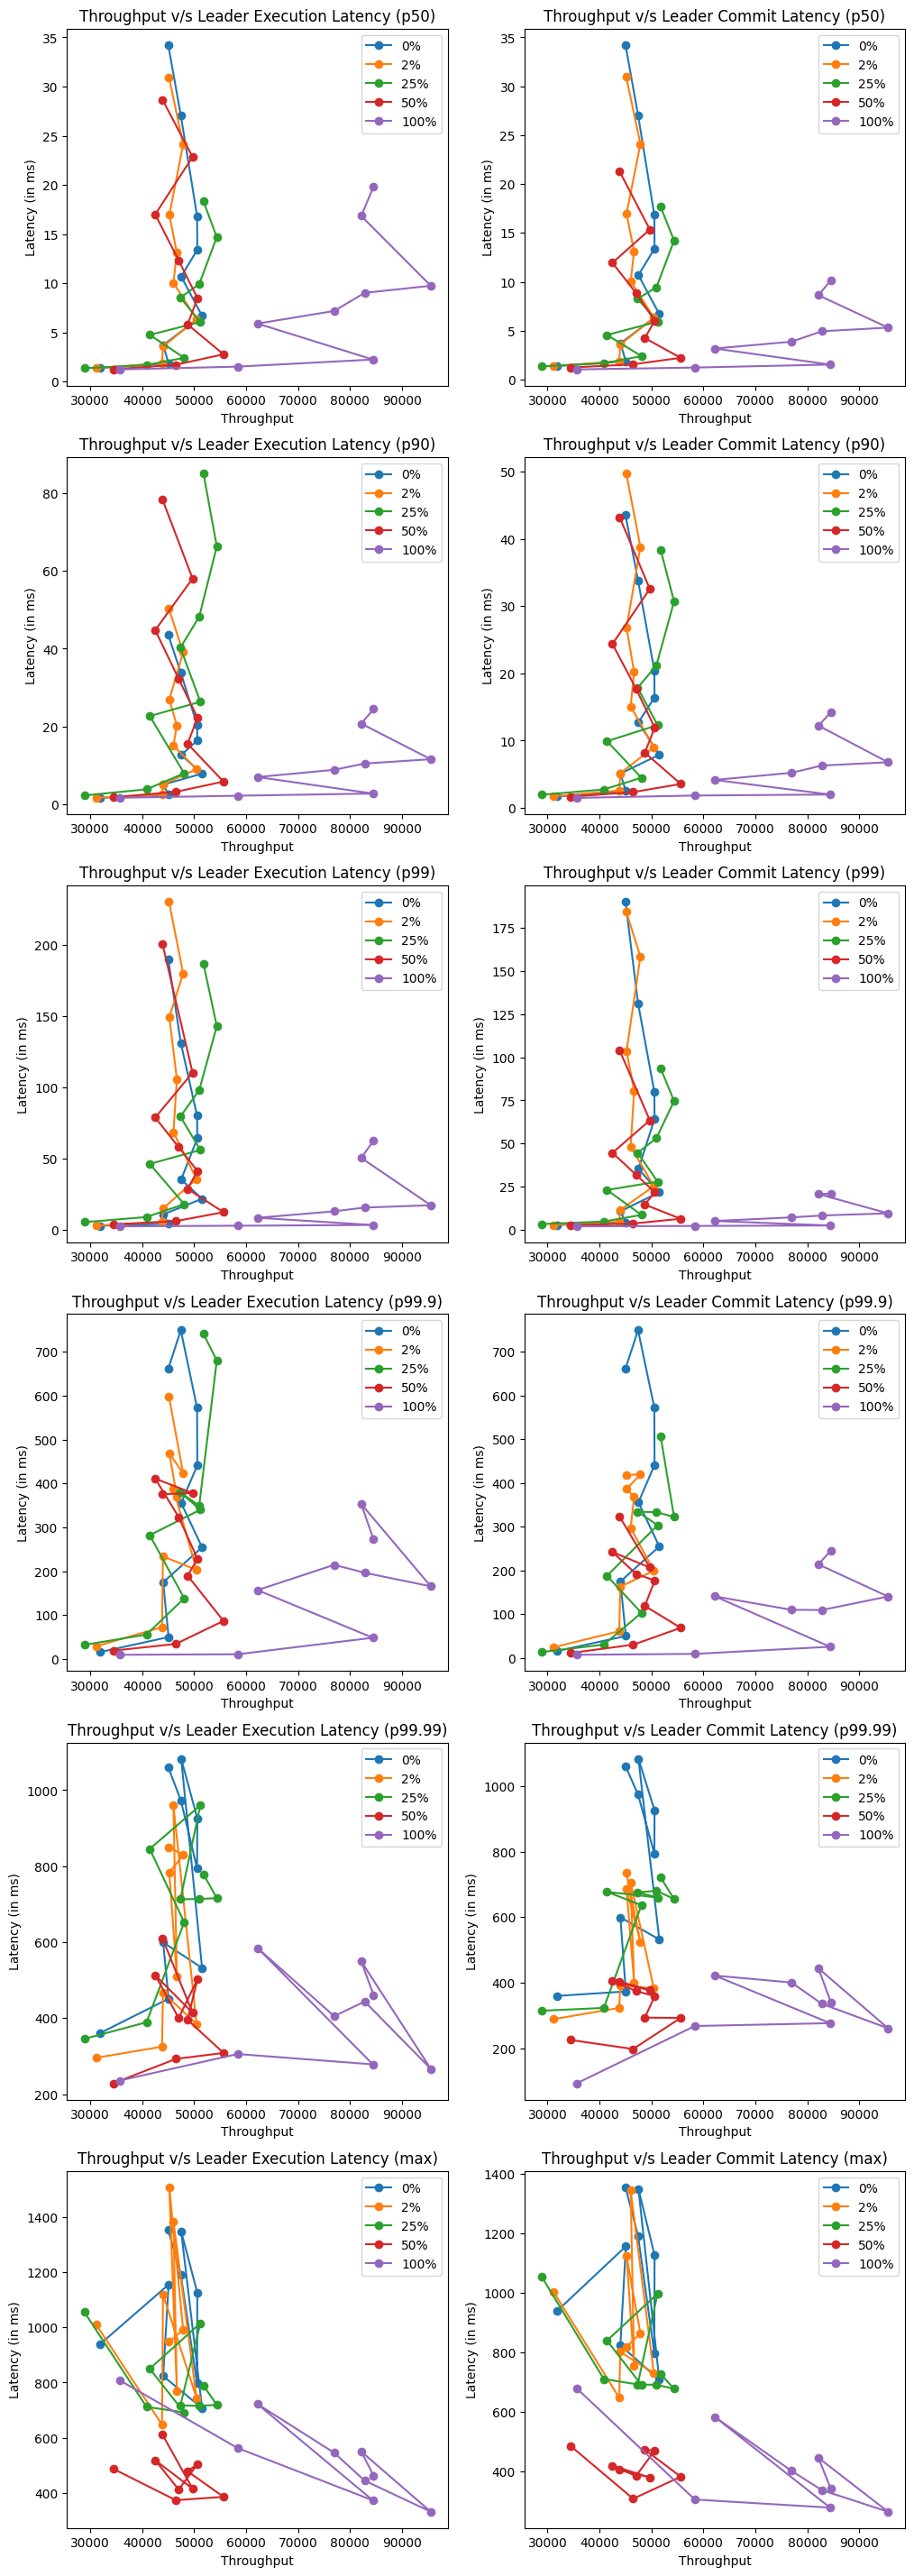

In [168]:
plt.close()
del conflict_throughputs['Concurrency']
fig, axes = plt.subplots(nrows=len(percentile_types), ncols=len(latency_types), figsize=(len(latency_types) * 6, len(percentile_types) * 6))
col = 0
for latency_type in latency_types:
    row = 0
    for percentile_type in percentile_types:
        for conflict in conflict_throughputs:
            y = output2[latency_type][percentile_type][int(conflict)]
            length = len(y)
            x = conflict_throughputs[conflict][0:length]
            axes[row][col].plot(x, y, label = str(conflict) + '%', marker = 'o')
        axes[row][col].set_xlabel('Throughput')
        axes[row][col].set_ylabel('Latency (in ms)')
        axes[row][col].legend()
        axes[row][col].set_title('Throughput v/s ' + titles[col] + ' Latency (' + percentile_type + ')')
        row += 1
    col += 1

plt.show()
        